Context: Mount Everest attracts many climbers, including highly experienced mountaineers. There are two main climbing routes, one approaching the summit from the southeast in Nepal (known as the standard route) and the other from the north in Tibet. While not posing substantial technical climbing challenges on the standard route, Everest presents dangers such as altitude sickness, weather, and wind, as well as hazards from avalanches and the Khumbu Icefall. As of November 2022, 310 people have died on Everest. Over 200 bodies remain on the mountain and have not been removed due to the dangerous conditions. The first recorded efforts to reach Everest's summit were made by British mountaineers. As Nepal did not allow foreigners to enter the country at the time, the British made several attempts on the north ridge route from the Tibetan side. After the first reconnaissance expedition by the British in 1921 reached 7,000 m (22,970 ft) on the North Col, the 1922 expedition pushed the north 

/var/folders/m0/bq55cd_d4ks7fz_vnjvd5ykm0000gp/T/ipykernel_89360/2644474295.py:88: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  green_cmap = plt.cm.get_cmap('Greens')


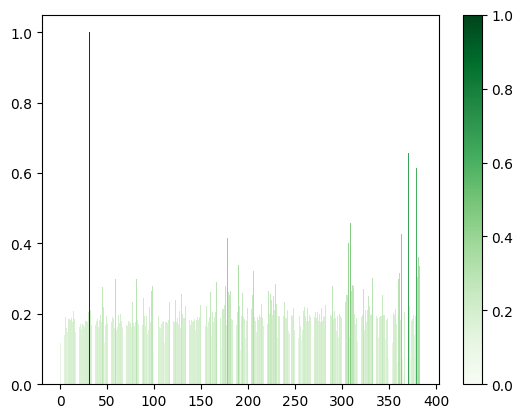

In [2]:
import torch
from lxt.models.gpt2 import GPT2LMHeadModel as CustomGPT, attnlrp 
from transformers import  GPT2Config
from transformers import AutoTokenizer
import matplotlib.pyplot as plt

def append_backward_hooks_to_mlp(m):

    rel_layer = {}
    def generate_hook(layer_name):
        def backward_hook(module, input_grad, output_grad):
            # cloning the relevance makes sure, it is not modified through memory-optimized LXT inplace operations if used
            rel_layer[layer_name] = output_grad[0].clone()
        return backward_hook

    # append hook to last activation of mlp layer
    for name, layer in m.named_modules():
        if name.endswith("mlp"):
            layer.register_full_backward_hook(generate_hook(name))
            

    return rel_layer

# An even smaller LLaMA to use as an example
model_id = "/Users/tom/Downloads/gpt2"
# model_id = "/Users/tom/Downloads/mini-llama"
prompt = """Context: Mount Everest attracts many climbers, including highly experienced mountaineers. There are two main climbing routes, one approaching the summit from the southeast in Nepal (known as the standard route) and the other from the north in Tibet. While not posing substantial technical climbing challenges on the standard route, Everest presents dangers such as altitude sickness, weather, and wind, as well as hazards from avalanches and the Khumbu Icefall. As of November 2022, 310 people have died on Everest. Over 200 bodies remain on the mountain and have not been removed due to the dangerous conditions. The first recorded efforts to reach Everest's summit were made by British mountaineers. As Nepal did not allow foreigners to enter the country at the time, the British made several attempts on the north ridge route from the Tibetan side. After the first reconnaissance expedition by the British in 1921 reached 7,000 m (22,970 ft) on the North Col, the 1922 expedition pushed the north ridge route up to 8,320 m (27,300 ft), marking the first time a human had climbed above 8,000 m (26,247 ft). The 1924 expedition resulted in one of the greatest mysteries on Everest to this day: George Mallory and Andrew Irvine made a final summit attempt on 8 June but never returned, sparking debate as to whether they were the first to reach the top. Tenzing Norgay and Edmund Hillary made the first documented ascent of Everest in 1953, using the southeast ridge route. Norgay had reached 8,595 m (28,199 ft) the previous year as a member of the 1952 Swiss expedition. The Chinese mountaineering team of Wang Fuzhou, Gonpo, and Qu Yinhua made the first reported ascent of the peak from the north ridge on 25 May 1960. \
Question: How high did they climb in 1922? According to the text, the 1922 expedition reached 8,"""
print(prompt)

# Setup model and tokenizer
config=GPT2Config.from_pretrained(model_id,local_files_only=True)
model=CustomGPT.from_pretrained(model_id,local_files_only=True,config=config)
tokenizer = AutoTokenizer.from_pretrained(model_id,local_files_only=True)
attnlrp.register(model)
layers=append_backward_hooks_to_mlp(model)

token_id=-1
max_length=512
input_ids = tokenizer(prompt, return_tensors="pt", add_special_tokens=True).input_ids.to(model.device)
prompt_length = input_ids.shape[1]
relevances = []

while token_id != tokenizer.eos_token_id and input_ids.shape[1] < max_length:
    
    input_embeds = model.get_input_embeddings()(input_ids)
    output_logits = model(inputs_embeds=input_embeds.requires_grad_(), use_cache=False).logits
    max_logits, max_indices = torch.max(output_logits[0, -1, :], dim=-1)
    # output token id
    token_id = max_indices.item()
    # output token
    output_token=tokenizer.decode(token_id)
    print(output_token, end=" ")
    # update input
    input_ids = torch.cat([input_ids, torch.tensor([token_id]).unsqueeze(0)], dim=1)
    # Get LXT relevance
    max_logits.backward(max_logits)
    relevance = input_embeds.grad.float().sum(-1).cpu()[0]
    relevance = relevance / relevance.abs().max()
    relevances.append(relevance)
    # print(layers)
    
total_length = input_ids.shape[1]
output_length = total_length - prompt_length
assert output_length == len(relevances)

source_relevance = [x[:prompt_length] for x in relevances]
source_relevance_mean = torch.mean(torch.stack(source_relevance), dim=0)


# print(source_relevance_mean)
# source_relevance_abs=torch.abs(source_relevance_mean)
source_relevance_normalized=(source_relevance_mean - source_relevance_mean.min()) / (source_relevance_mean.max() - source_relevance_mean.min())
# source_relevance_normalized-=source_relevance_normalized.min()
zero_indices = torch.nonzero(source_relevance_normalized == 0).squeeze()
input_tokens=tokenizer.convert_ids_to_tokens(input_ids[0,:].tolist())

_,bottom_k=torch.topk(-source_relevance_normalized, k=100)
_,top_k=torch.topk(source_relevance_normalized, k=100)
print("\n--------------bottom k----------------\n")
for i in bottom_k:
    print(input_tokens[i],end=" ")
print("\n--------------top k----------------\n")
for i in top_k:
    print(input_tokens[i],end=" ")

# 定义一个颜色映射，这里使用绿色
green_cmap = plt.cm.get_cmap('Greens')
fig, ax = plt.subplots()

# Bar plot
ax.bar(range(len(source_relevance_normalized)), source_relevance_normalized, color=green_cmap(source_relevance_normalized))

# ScalarMappable for the colorbar
sm = plt.cm.ScalarMappable(cmap=green_cmap, norm=plt.Normalize(vmin=source_relevance_normalized.min(), vmax=source_relevance_normalized.max()))
sm.set_array([])

# Add colorbar to the figure
cbar = fig.colorbar(sm, ax=ax)

